In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#all the good old hyperparameters.
np.random.seed(1234)
tf.set_random_seed(1234)
samples = 300
noise = 0.67
NUM_BATCHES= 1000
lr = .01
latentDim = 613
latentDim2= 613
# latentDim4= 10
lamb = 0.3
batch_size = 10
#h is resolution for descion plot
h = 0.1
circles = 150

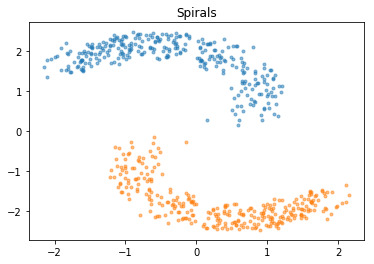

In [3]:
#derived this method for creating data from:https://goo.gl/s46c9a

n = np.sqrt(np.random.rand(samples,1)) * circles * (2*np.pi)/360
#sampling numbers from 0 to 780 (a little more than 2* 360) then convert it to raidans
#trig functions go from -1,1, by scaling it by n we are making them go from ~0 to 15 
#add some noise to make it tasty.
x1 = np.cos(n)*n + np.random.rand(samples,1) * noise
#x1 = np.log(n)
#x2 =  n*np.log(n)
x2 = np.sin(n)*n + np.random.rand(samples,1) * noise
Spiral1 = np.hstack((x1,x2))
Spiral2 = np.hstack((-x1,-x2))
Y = np.hstack((np.zeros(samples),np.ones(samples)))
plt.title("Spirals")
plt.plot(Spiral1[0:-1,0], Spiral1[0:-1,1], ".", label="Spiral 1", alpha=0.5)
plt.plot(Spiral2[0:-1,0], Spiral2[0:-1,1], ".", label="Spiral 2", alpha=0.5)
Spirals = np.vstack((Spiral1,Spiral2))



In [4]:
w1 = tf.get_variable('w1', [2, latentDim], tf.float32, tf.random_normal_initializer())
w2 = tf.get_variable('w2', [latentDim, latentDim2], tf.float32, tf.random_normal_initializer())
w3 = tf.get_variable('w3', [latentDim2, 1], tf.float32, tf.random_normal_initializer())
# w4 = tf.get_variable('w4', [latentDim3, latentDim4], tf.float32, tf.random_normal_initializer())
# w5 = tf.get_variable('w5', [latentDim4, 1], tf.float32, tf.random_normal_initializer())
b1 = tf.get_variable('b1', [1,latentDim], tf.float32, tf.zeros_initializer())
b2 = tf.get_variable('b2', [1, latentDim2], tf.float32, tf.zeros_initializer())   
b3 = tf.get_variable('b3', [1,1], tf.float32, tf.zeros_initializer())
# b4 = tf.get_variable('b4', [1,latentDim4], tf.float32, tf.zeros_initializer())
# b5 = tf.get_variable('b5', [1,1], tf.float32, tf.zeros_initializer())

In [5]:
#The f(x) we get is not going to produce a probability, we are going to leave that to the TF cross entropy loss boy.
def f(x): 
    return tf.matmul(tf.nn.tanh(tf.matmul(tf.nn.tanh(tf.matmul(x,w1)+ b1), w2) + b2),w3) + b3    
#     return tf.matmul(tf.nn.tanh(tf.matmul(tf.nn.tanh(tf.matmul(tf.nn.tanh(tf.matmul(tf.nn.tanh(tf.matmul(x,w1)+ b1), w2) + b2),w3) + b3), w4) + b4), w5) + b5

In [6]:
x = tf.placeholder(tf.float32, [batch_size,2])
y = tf.placeholder(tf.float32, [batch_size,1])

y_hat = f(x)
loss = tf.losses.sigmoid_cross_entropy(y,y_hat,label_smoothing=5) + lamb*(tf.pow(tf.norm(w1),2) + tf.pow(tf.norm(w2),2))

#loss = tf.losses.sigmoid_cross_entropy(y,y_hat) 
#loss = tf.losses.sigmoid_cross_entropy(y,y_hat) + lamb*(tf.pow(tf.norm(w1),2) + tf.pow(tf.norm(w2),2) + tf.pow(tf.norm(w3),2) + tf.pow(tf.norm(w4),2) + tf.pow(tf.norm(w5),2))
optim = tf.train.AdagradOptimizer(lr).minimize(loss)
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

In [7]:
for _ in tqdm(range(0, NUM_BATCHES)):
    choices = np.random.choice(samples,batch_size)
    x_np = Spirals[choices]
    y_np = np.array(Y[choices]).reshape((batch_size,1))
    loss_np, _ = sess.run([loss, optim], feed_dict={x: x_np, y: y_np})
#     print(loss_np)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.70it/s]


In [8]:
#Now need to plot the descion boundary. 

#basically we are just going to sample a bunchacrunch points, pass em through the network and then matplotlib do a filled contour

xx,yy = np.meshgrid(np.arange(-7,7,h), np.arange(-7,7,h))
inputx = np.stack((xx,yy), axis=2)


In [9]:
y_hats = np.array([])
a = tf.placeholder(tf.float32, [inputx.shape[0],2])
y_hat = f(a)

for i in tqdm(range(inputx.shape[0])):
    if y_hats.size>0: 
        y_hats = np.hstack((y_hats,sess.run(y_hat,{a:inputx[i]})))
    else: 
        y_hats = sess.run(y_hat,{a:inputx[i]})
    


100%|███████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 216.96it/s]


In [10]:
#change them either to have zero or 1....
y_hats[y_hats>0] = 1
y_hats[y_hats<=0] = 0

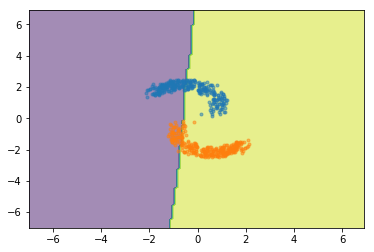

In [11]:
plt.contourf(xx,yy,y_hats,alpha=0.5)

plt.plot(Spiral1[0:-1,0], Spiral1[0:-1,1], ".", label="Spiral 1", alpha=0.5)
plt.plot(Spiral2[0:-1,0], Spiral2[0:-1,1], ".", label="Spiral 2", alpha=0.5)